# Bases de datos

La base de datos [ENA](https://www.ebi.ac.uk/ena/browser/home) ofrece la posibilidad de realizar las consultas de forma *programática*: desde un *script* o desde la línea de comandos de un terminal tipo *BASH*. En un terminal, los programas `curl` y `wget` permiten descargar contenidos de la red. En el entorno de R también disponemos de un paquete llamado `curl` que nos permite descargar información de internet.

El objetivo de esta práctica es componer un *script* de R que represente gráficamente la evolución de la cantidad de datos de secuencias cortas en ENA en los últimos años. Es decir, pretendemos reproducir y actualizar el gráfico **Reads growth** mostrado en las [estadísticas de ENA](https://www.ebi.ac.uk/ena/browser/about/statistics).

Este documento te ofrece un ejemplo de los pasos a seguir, que tendrás que editar para que el script cumpla la función deseada. Es decir, utiliza los bloques de código de este documento como plantilla para confeccionar tu propio script. Puedes abrir un nuevo cuaderno jupyter (`File` $\rightarrow$ `New Notebook` $\rightarrow$ `R`). Si conoces RStudio y prefieres hacerlo allí, también puedes abrir una sesión de RStudio desde esta sesión en mybinder.org.

## Libreria *curl*

Primero cargamos el paquete *curl* y lo usamos para descargar la documentación más reciente sobre la manera de consultar ENA mediante línea de comandos.

In [1]:
library('curl')
curl_download(url = 'https://www.ebi.ac.uk/ena/portal/api/doc?format=pdf',
              destfile = 'apiEna.pdf')

Using libcurl 7.68.0 with GnuTLS/3.6.13



El paquete *curl* ofrece otras funciones para descargar contenidos. Usaremos `curl_download`, que siempre guarda los contenidos descargados en un archivo.

## La API de ENA

Una *interfaz de programación de aplicaciones* (API) es la forma de comunicarse entre dos aplicaciones. En este caso: la base de datos de ENA y nuestro script. La API de ENA consiste en las reglas que traducen una búsqueda concreta a una dirección de internet o *URL*. Esta URL se compone de:

- La dirección del portal `htpps://www.ebi.ac.uk/ena/portal/api`.
- El *endpoint* `/search`, que especifica que vamos a buscar algo.
- Los parámetros de búsqueda, separados por "&" y que incluyen:
    - *result*: este parámetro es obligatorio y especifica qué tipo de datos buscamos: *read_run*, *read_experiment*, *sample*, *study*, *sequence_release*, *wgs_set*, etc.
    - *query*: (opcional) condiciones o filtros de búsqueda unidos mediante "AND", "OR" o "NOT" y entrecomillados.
    - *fields*: (opcional) lista de campos (separados por comas) que se desea obtener (específicos del tipo de datos que buscamos; puede incluir: *scientific_name*, *collection_date*, *strain*, etc.
    - *limit*: (opcional) número máximo de registros que serán descargados. El 0 significa "todos".
    - *format*: (opcional) el formato por defecto es *tsv*, pero se puede solicitar *json*.
    
Podemos obtener una lista de los valores posibles del parámetro *result* mediante `https://www.ebi.ac.uk/ena/portal/api/results?dataPortal=ena`. Para un tipo de datos concreto de esa lista (e.g., *sample*), podemos conocer los campos de información que podemos usar como filtros o términos de búsqueda (*query*) mediante `https://www.ebi.ac.uk/ena/portal/api/searchFields?result=sample`. Así mismo, los campos disponibles para el informe de resultados se consultan así: `https://www.ebi.ac.uk/ena/portal/api/returnFields?result=sample`. Por último, para especificar valores exigidos a algunos términos de búsqueda (*query*), necesitamos conocer los valores permitidos (o vocabulario controlado): `https://www.ebi.ac.uk/ena/portal/api/controlledVocab?field=mol_type`.

Para hacer el código más claro y fácil de editar, defino como cadenas de caracteres las diferentes partes de la URL que queremos construir, y después las uno con `paste()`:

In [2]:
portal   <- 'https://www.ebi.ac.uk/ena/portal/api/'
endpoint <- 'search?'
# Busco genomas ensamblados...
result   <- 'result=assembly'
# ...y completos, de peces actinopterigios (NCBI taxon id 7898):
query    <- '&query=tax_tree(7898) AND genome_representation="full"'
fields   <- '&fields=version,tax_id,scientific_name,last_updated,base_count'
limit    <- '&limit=0'

#Ahora lo juntamos todo y comprobamos que queda bien:
URL <- paste0(portal, endpoint, result, query, fields, limit, sep='', collapse='')
URL

[1] "https://www.ebi.ac.uk/ena/portal/api/search?result=assembly&query=tax_tree(7898) AND genome_representation=\"full\"&fields=version,tax_id,scientific_name,last_updated,base_count&limit=0"

Parece que hemos construido la URL de forma correcta. Sin embargo, si intentas descargar su contenido en un archivo (`curl_download(URL, destfile='z1.tsv')`) obtendrás un error. El motivo es que en la URL aparecen espacios y caracteres reservados ("=", "(", ")") donde no se esperaban. El problema está en el fragmento `tax_tree(7898) AND genome_representation="full"`. Sólo en esa parte debemos sustituir los caracteres reservados por su representación en [código porciento](https://es.wikipedia.org/wiki/C%C3%B3digo_porciento). Por tanto, hay que definir `query` de nuevo para corregirlo.

In [3]:
query  <- paste('&query=',
                URLencode('tax_tree(7898) AND genome_representation="full"',
                          reserved = TRUE),
                sep = '', collapse = '')
URL <- paste(portal, endpoint, result, query, fields, limit, sep='', collapse='')
URL

[1] "https://www.ebi.ac.uk/ena/portal/api/search?result=assembly&query=tax_tree%287898%29%20AND%20genome_representation%3D%22full%22&fields=version,tax_id,scientific_name,last_updated,base_count&limit=0"

Fíjate en el uso de las funciones `paste()` y `URLencode()`. Puedes aprender sobre el significado de sus argumentos mediante `help(paste)` y `help(URLencode)`.

### Ejercicio 1
Teniendo en cuenta lo que has aprendido, construye ahora una consulta en formato de URL para descargar: la fecha de publicación, el número de lecturas y el número de bases de los 100000 primeros registros de tipo *read_run*. (Limitamos el número de registros para no saturar la RAM).


## Guardar y cargar los resultados

In [4]:
curl_download(URL, destfile = 'fish.tsv')

Con esto debe haber aparecido el archivo `fish.tsv` en la carpeta de trabajo. Puede parecer poco eficiente usar R para descargar un archivo y después volver a leerlo en R, cuando la función `curl_fetch_memory()` cargaria directamente el contenido de la URL en la memoria de trabajo. Pero es más fácil así y evita saturar la memoria de trabajo si el contenido descargado fuese muy grande.

Ahora, pues, toca leer el archivo descargado, usando la función `read.table()`:

In [5]:
fish <- read.table('fish.tsv',
             header = TRUE,
             colClasses = c('character','numeric','numeric','character','Date','numeric'),
             sep = '\t',
             na.strings = '')
head(fish, n = 12)

,accession,version,tax_id,scientific_name,last_updated,base_count
,<chr>,<dbl>,<dbl>,<chr>,<date>,<dbl>
1,GCA_000002035,3,7955,Danio rerio,2017-05-08,1371702787
2,GCA_000150855,1,35575,Mchenga conophoros,2016-11-29,73425564
3,GCA_000150875,1,57307,Labeotropheus fuelleborni,2016-11-29,70858381
4,GCA_000150895,1,27751,Melanochromis auratus,2016-11-29,68238634
5,GCA_000150935,1,163638,Rhamphochromis esox,2016-11-29,71295074
6,GCA_000151825,1,8090,Oryzias latipes,2016-11-29,662701370
7,GCA_000180615,2,31033,Takifugu rubripes,2013-12-05,391468278
8,GCA_000180675,1,69293,Gasterosteus aculeatus,2019-08-27,446610788
9,GCA_000180735,1,99883,Tetraodon nigroviridis,2019-08-27,342403326


Observa las primeras líneas de los datos que hemos cargado en memoria. El objeto `fish` es un *data frame*, un tipo de tabla en R en que cada columna es una variable. 

### Ejercicio 2
Descarga los resultados de la búsqueda confeccionada en el **ejercicio 1** y cárgalos en la memoria o espacio de trabajo de R. 

## Contar las bases por fecha
Para representar gráficamente la acumulación de registros y del número de bases total a lo largo del tiempo, necesitamos hacer algunas operaciones. Concretamente, para cada fecha (columna *last updated*) debemos sumar el número de bases totales (*base_count*) y contar el número de registros actualizados en esa fecha. Empezemos por aquí. Este tipo de operaciones que se aplican por separado a cada pedazo de una tabla y luego se reunen en otra tabla se pueden hacer bastante bien con el paquete `plyr`:

In [6]:
library(plyr)
# La función ddply() de plyr toma como datos iniciales un data frame,
# lo divide en tantos data frames como valores diferentes tenga la(s)
# variable(s) indicada(s), aplica una función a cada porción, y reúne
# los resultados en otro data frame.
PorFecha <- ddply(.data = fish,
                  .variables = 'last_updated',
                  .fun = function(x) data.frame(bases = sum(x$base_count, na.rm=TRUE),
                                                registros = nrow(x)))
head(PorFecha)

,last_updated,bases,registros
,<date>,<dbl>,<int>
1,2012-02-09,927725912,1
2,2012-11-20,869801494,1
3,2013-09-20,2391207647,3
4,2013-09-23,945861706,1
5,2013-10-28,756296653,1
6,2013-12-05,391468278,1


Si te interesa, puedes aprender a usar el paquete `plyr` en este [tutorial](http://swcarpentry.github.io/r-novice-gapminder/12-plyr/index.html).

Hay otras formas de hacerlo. Por ejemplo, con la función `aggregate()`, disponible por defecto, que aplica una función a cada trozo de un *data frame* delimitado por las filas que tienen el mismo valor de un factor (o la misma combinación de valores de más de un factor). Por ejemplo, para sumar el número de bases secuenciadas en la misma fecha, podemos hacer lo siguiente:

In [7]:
BasesPorFecha <- aggregate(fish$base_count, by = list(date=fish$last_updated), sum)
head(BasesPorFecha)

,date,x
,<date>,<dbl>
1,2012-02-09,927725912
2,2012-11-20,869801494
3,2013-09-20,2391207647
4,2013-09-23,945861706
5,2013-10-28,756296653
6,2013-12-05,391468278


Usaremos la tabla `PorFecha` obtenida con `ddply()`, que contiene el número de registros y el número de bases que fueron actualizados en cada fecha. Lo podemos representar gráficamente:

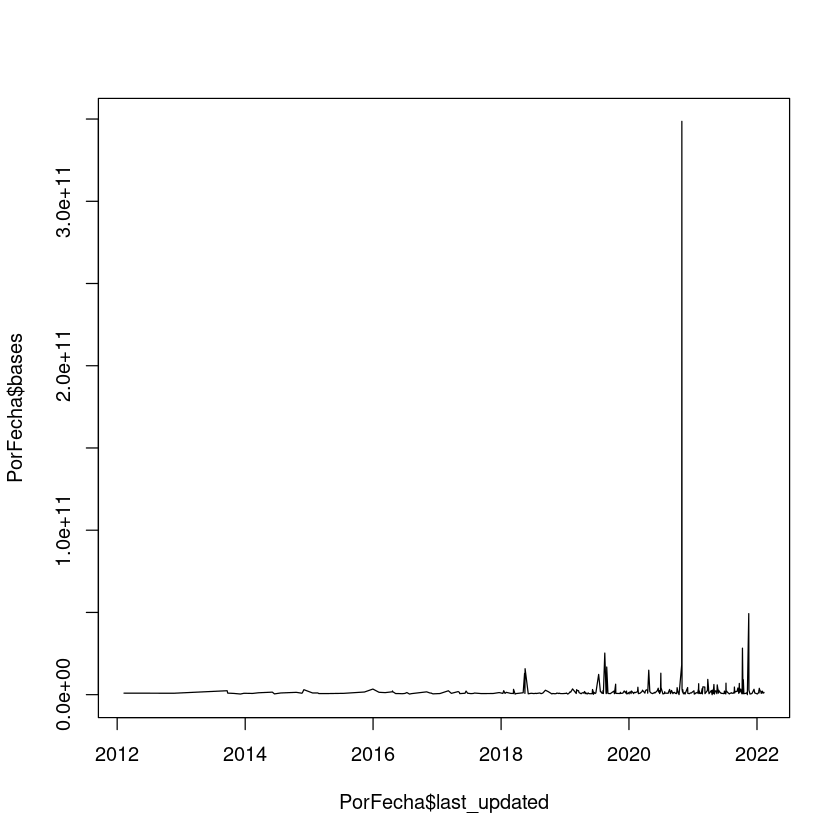

In [8]:
plot(PorFecha$last_updated, PorFecha$bases, type='l')

In [9]:
head(PorFecha[order(PorFecha$bases, decreasing=TRUE),])

,last_updated,bases,registros
,<date>,<dbl>,<int>
229,2020-10-29,348607681506,504
333,2021-11-15,49273298127,63
325,2021-10-10,28273756929,36
141,2019-08-16,25289550173,30
228,2020-10-28,18041875980,26
145,2019-08-27,16813719246,20


Al ordenar las líneas de la tabla `PorFecha`, vemos fácilmente en qué fechas se actualizaron más registros. **¿Sabrías averiguar a qué especies corresponden los 505 registros del 29 de octubre de 2020?**

### Ejercicio 3
Utiliza la función `ddply()` para agrupar el número de lecturas cortas y el número de bases publicadas en ENA en cada fecha.

## Suma acumulada

Lo que necesitamos ahora es añadir a la tabla `PorFecha` una columna con la suma *acumulada* de bases, y la de registros. Podemos comprobar que la tabla está de hecho ordenada por fechas y entonces aplicar la función `cumsum()`:

In [ ]:
dim(fish)

In [ ]:
is.unsorted(PorFecha$last_updated)

In [ ]:
PorFecha$basesAcumuladas     <- cumsum(PorFecha$bases)
PorFecha$registrosAcumulados <- cumsum(PorFecha$registros)
tail(PorFecha)

Arriba muestro el final de la table con la función `tail()` en lugar de mostrar el principio porque quiero ver si la suma acumulada ha funcionado. **¿Qué crees que hubiera ocurrido si en la tabla original `fish` tuviéramos un registro con un número desconocido `NA` de bases?**

A continuación, lo representamos gráficamente, usando una escala logarítmica para el número de bases acumuladas.

In [ ]:
plot(PorFecha$last_updated, PorFecha$basesAcumuladas,
     type = 'l', log = 'y',
     xlab = 'Fecha', ylab = 'Núm. bases acumuladas',
     main = 'Genomas de peces óseos')

### Ejercicio 4
Calcula y representa gráficamente el número acumulado de lecturas cortas y de bases a lo largo del tiempo, con los 100000 primeros registros de *read_run* que has descargado de ENA. 

## Para concluir

- ¿Qué ventajas tiene realizar las consultas de manera programática, en lugar de hacerlo mediante la interfaz gráfica?
- ¿Qué problemas podría haber para actualizar automáticamente la gráfica ejecutando el mismo script dentro de 10 años? ¿Y dentro de 100?
- ¿Has *anotado* tu script con comentarios? ¿Por qué?
- ¿Conoces alguna herramienta para poder mostrar, compartir y editar conjuntamente un script de forma remota con otras personas?
